# Grand Average Analysis

In this file we investigate the grand average of all subjets in the Instagram study. We also take a look at the visualized EEG data as first exploratory steps.

---

This notebook reads in the *-epo.fif* evoked files from individual subjects that were produced by the batch preprocessing notebook. 

Assumes that the data from each subject are in a sub-folder named for that subject, and that these subject sub-folders are in the same folder as this script.

---
Based on work by Aaron J Newman; Copyright (c) 2016 Aaron J Newman, NeuroCognitive Imaging Lab, Dalhousie University

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301, USA.

---

In [173]:
# This is an attempt to produce the results without repeating the analytical steps using the evokeds files.

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 72  
figsize=(4, 4)

import mne
import mne.stats
import numpy as np
mne.set_log_level('error')

data_path = '.'

subjects = [
     'ID01',
     'ID02',
     'ID03',
     'ID04',
     'ID05',
     'ID06',
     'ID07',
     'ID08',
     'ID09',
     'ID10',
     'ID11',
     'ID12',
     'ID13',
     'ID14',
     'ID15',
     'ID16',
     'ID17',
     'ID18',
     'ID19',
     'ID20',
    'P00',
    'P01',
]

In [67]:
# Amount of time to shift event codes by, based on empirical testing with photocell
#  to determine lag between event code and actual stimulus appearance on screen.
#  For reasons that are unclear, we need to double this value (in sec) to get the correct shift
tshift = 0.169 

baseline = (None, 0)


## Specify time windows of interest

In [3]:
P3_timewin = (0.200, 0.600) 
LPP_timewin = (0.600, 2.000)
N170_timewin = (130, 200)
N400_timewin = (300, 500)

## Difference waves which you may want to compute

In [89]:
conditions = ['HI', 'VI']
influencers = ['HI/adhelbol', 'HI/chiaraferragni', 'HI/emilycanham', 'HI/flaviapava','HI/imjennim', 'HI/jihye', 'HI/lamise', 
                     'HI/rosesarerosie', 'HI/simoneses', 'HI/sooyaa', 'VI/bermudaisbae', 'VI/iamxalara', 'VI/immagram', 
                      'VI/leyalovenat', 'VI/lilmiquela', 'VI/magazineluiza', 'VI/noonouri', 'VI/rozygram', 'VI/shudugram', 'VI/soymaria']

contrasts = {'Human-Virtual':['HI', 'VI']}

## Load epochs

In [68]:
epochs = {}
for subject in subjects:
    epochs[subject] = mne.read_epochs(str(data_path + '/Epochs/' + subject +'-epo.fif'),
                                         proj=False, 
                                         verbose=None, 
                                         preload=True)
    # correct for stimulus presentation delay
    epochs[subject]._raw_times = epochs[subject]._raw_times - tshift
    epochs[subject]._times_readonly = epochs[subject]._times_readonly - tshift
    epochs[subject].apply_baseline(baseline)

## Compute evokeds

In [69]:
evoked = {}

for cond in conditions:
    evoked[cond] = [epochs[subject][cond].average() for subject in subjects]

In [70]:
evoked

{'HI': [<Evoked | '0.10 × HI/adhelbol + 0.10 × HI/chiaraferragni + 0.10 × HI/emilycanham + 0.10 × HI/flaviapava + 0.10 × HI/imjennim + 0.10 × HI/jihye + 0.10 × HI/lamise + 0.10 × HI/rosesarerosie + 0.10 × HI/simoneses + 0.10 × HI/sooyaa' (average, N=40), -0.36822 – 1.831 sec, baseline -0.368219 – 0 sec, 32 ch, ~333 kB>,
  <Evoked | '0.10 × HI/adhelbol + 0.10 × HI/chiaraferragni + 0.10 × HI/emilycanham + 0.10 × HI/flaviapava + 0.10 × HI/imjennim + 0.10 × HI/jihye + 0.10 × HI/lamise + 0.08 × HI/rosesarerosie + 0.10 × HI/simoneses + 0.10 × HI/sooyaa' (average, N=39), -0.36822 – 1.831 sec, baseline -0.368219 – 0 sec, 32 ch, ~333 kB>,
  <Evoked | '0.10 × HI/adhelbol + 0.10 × HI/chiaraferragni + 0.10 × HI/emilycanham + 0.10 × HI/flaviapava + 0.10 × HI/imjennim + 0.10 × HI/jihye + 0.10 × HI/lamise + 0.10 × HI/rosesarerosie + 0.10 × HI/simoneses + 0.10 × HI/sooyaa' (average, N=40), -0.36822 – 1.831 sec, baseline -0.368219 – 0 sec, 32 ch, ~333 kB>,
  <Evoked | '0.08 × HI/adhelbol + 0.06 × HI/ch

## Create grand averages for each macro condition

In [71]:
gavg = {}
for cond in conditions:
    gavg[cond] = mne.grand_average(evoked[cond])
gavg  

{'HI': <Evoked | 'Grand average (n = 22)' (average, N=22), -0.36822 – 1.831 sec, baseline -0.368219 – 0 sec, 32 ch, ~333 kB>,
 'VI': <Evoked | 'Grand average (n = 22)' (average, N=22), -0.36822 – 1.831 sec, baseline -0.368219 – 0 sec, 32 ch, ~333 kB>}

## Compute contrasts

In [90]:
evoked_diff = {}
for contr, conds in contrasts.items():
    evoked_diff[contr] = [mne.combine_evoked([ c1, c2],
                                             weights=[1, -1])
                          for (c1, c2) in zip(evoked[conds[0]], evoked[conds[1]])
                         ]

## Define ROIs


In [106]:
ch_names = epochs[subjects[0]].ch_names

roi_mapping = {'LPPa':['Cz', 'Fz', 'FC1', 'FC2'],
               'N400':['FC1', 'FC2','Cz', 'CP1', 'CP2'],
               'LPP':['Cz', 'CP1', 'CP2', 'Pz'],
               'Post':['P3', 'Pz', 'P4', 'O1', 'Oz', 'O2']
              }

rois = {}

for region in roi_mapping.keys():
    rois[region] = [ch_names.index(chan) for chan in roi_mapping[region]]

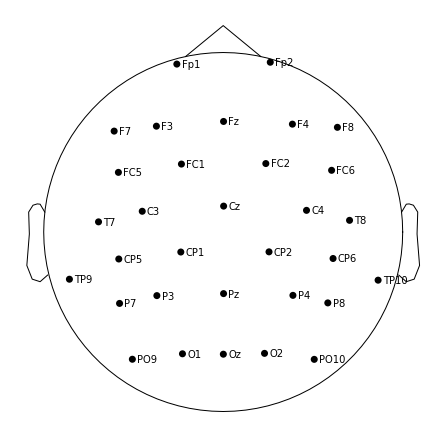

In [102]:
gavg['HI'].plot_sensors(show_names=True);

## Plot peaks for each condition

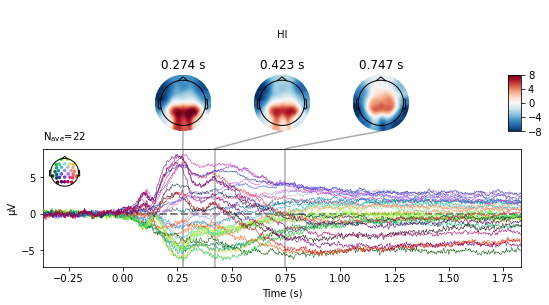

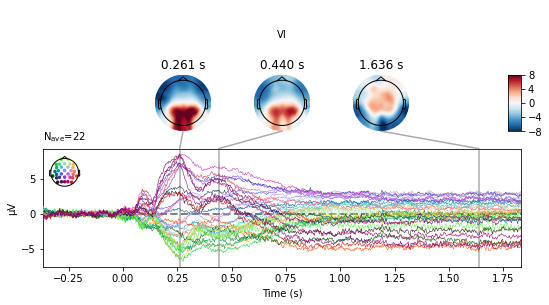

In [73]:
uv_range = 8

for cond in conditions:
     gavg[cond].plot_joint(times='peaks',
                             title=(cond), 
                             ts_args={'hline':[0]},
                             topomap_args={'sensors':False, 'contours':False, 
                                           'vmin':-uv_range, 'vmax':uv_range})

## Plot topomaps for each condition

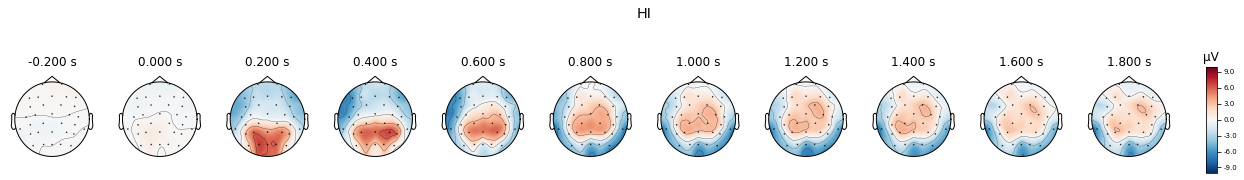

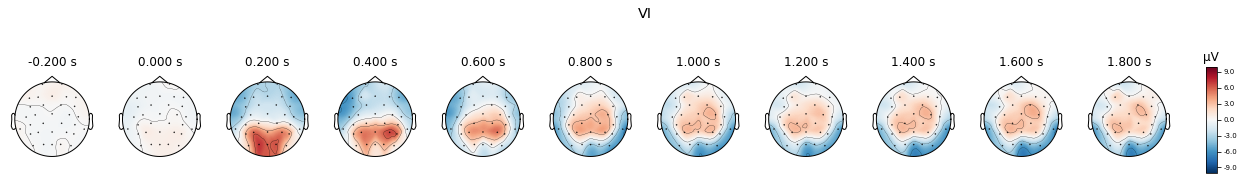

In [74]:
times = np.arange(-0.2, 2.000, 0.2)

for cond in gavg:
    [gavg[cond].plot_topomap(times=times, title=cond, vmin=-10, vmax=10)];

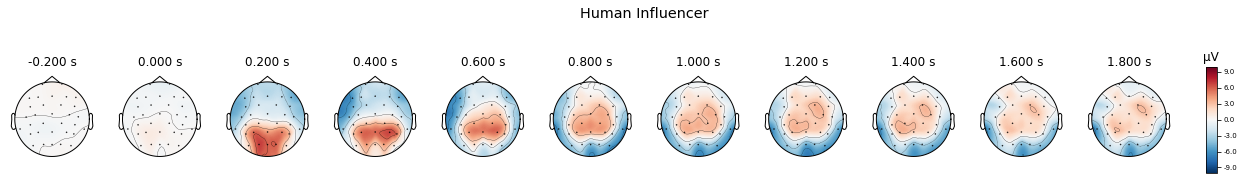

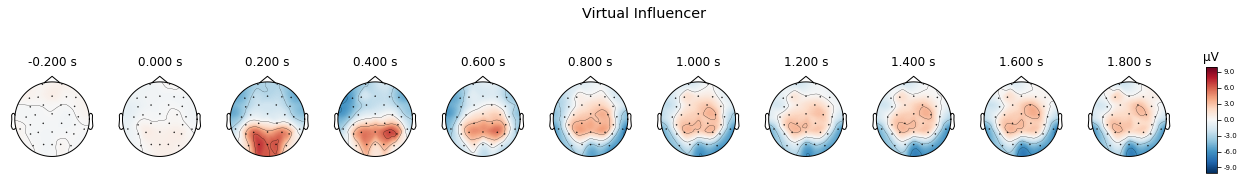

In [75]:
nega = gavg['HI'].plot_topomap(times=times, title='Human Influencer', vmin=-10, vmax=10)
nega.dpi = 160
nega.savefig('fig1_HI.png')

neut = gavg['VI'].plot_topomap(times=times, title='Virtual Influencer', vmin=-10, vmax=10)
neut.dpi = 160
neut.savefig('fig1_VI.png')

# Plot midline electrodes

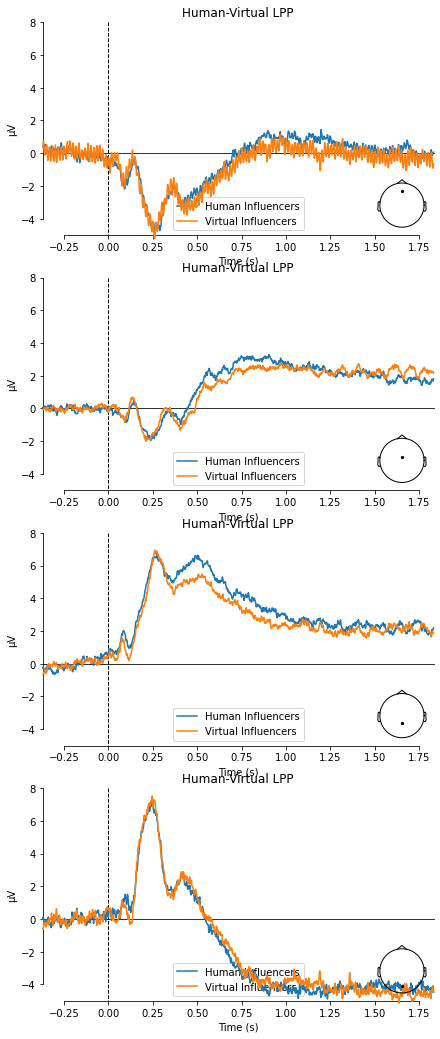

In [175]:
waveplot_figsize = (7, 18)
ylim = {'eeg':[-5, 8]}
mid_elec = ['Fz', 'Cz', 'Pz', 'Oz']

for contr in contrasts:
    fig, axs = plt.subplots(4, 1, figsize=waveplot_figsize)   
    ax = 0
    for chans in mid_elec:
        if ax < len(mid_elec):
            show=False
        else:
            show=True
            
        mne.viz.plot_compare_evokeds({'Human Influencers':evoked['HI'], 
                                      'Virtual Influencers':evoked['VI']},
                                     picks=chans, combine='mean',
                                     title=(contr + ' ' + roi),
                                     ylim=ylim,
                                     show_sensors='lower right', legend='lower center', 
                                     ci=False,
                                     axes=axs[ax], show=show
                                    )
        
        ax += 1

#     fig.savefig('./fig1_waveforms_aaron.png', dpi=300)
    plt.show()

## Plot ROIs

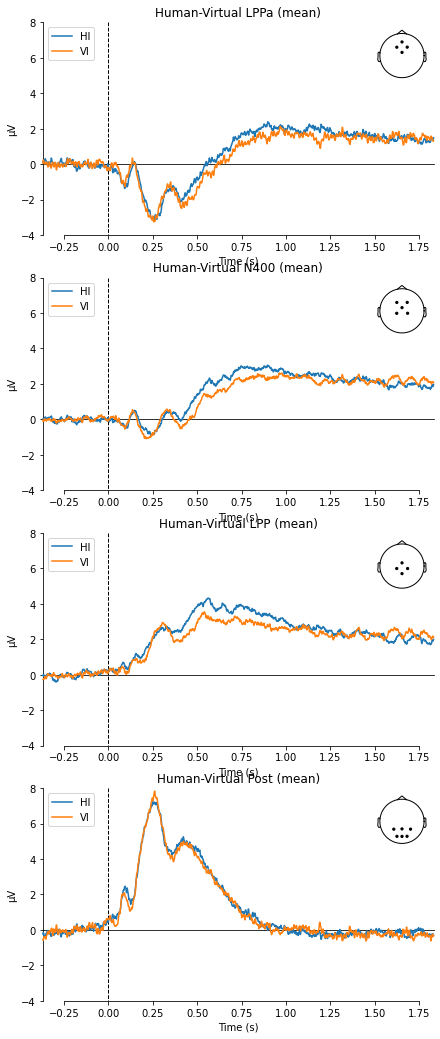

In [135]:
import matplotlib.pyplot as plt
waveplot_figsize = (7, 18)
ylim = {'eeg':[-4, 8]}

for contr in contrasts:
    fig, axs = plt.subplots(4, 1, figsize=waveplot_figsize)   
    ax = 0
    for roi, chans in roi_mapping.items():
        if ax < 3:
            show=False
        else:
            show=True
            
        mne.viz.plot_compare_evokeds({c:evoked[c] for c in conditions},
                                     picks=chans, combine='mean',
                                     title=(contr + ' ' + roi),
                                     ylim=ylim,
                                     show_sensors='upper right', legend=True, 
                                     ci=False,
                                     axes=axs[ax], show=show
                                    )
        ax += 1
    plt.show()

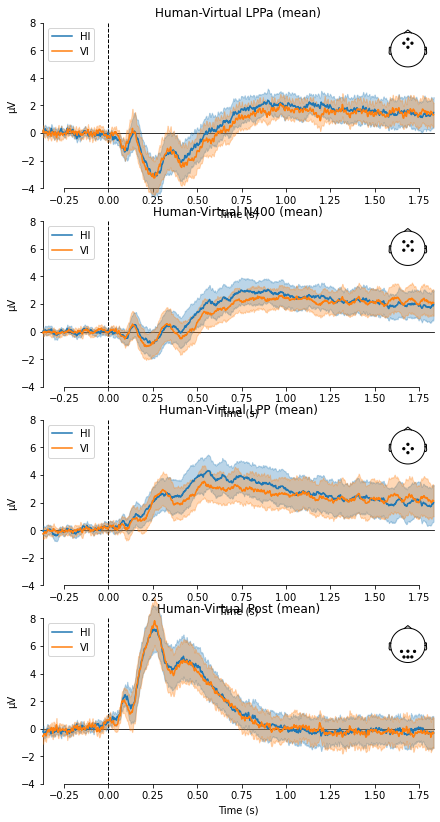

In [111]:
import matplotlib.pyplot as plt
waveplot_figsize = (7, 14)
ylim = {'eeg':[-4, 8]}

for contr in contrasts:
    fig, axs = plt.subplots(4, 1, figsize=waveplot_figsize)   
    ax = 0
    for roi, chans in roi_mapping.items():
        if ax < 3:
            show=False
        else:
            show=True
            
        mne.viz.plot_compare_evokeds({c:evoked[c] for c in conditions},
                                     picks=chans, combine='mean',
                                     title=(contr + ' ' + roi),
                                     ylim=ylim,
                                     show_sensors='upper right', legend=True, 
                                     ci=True,
                                     axes=axs[ax], show=show
                                    )
        ax += 1
    plt.show()

## Plot Difference between conditions for the whole time frame

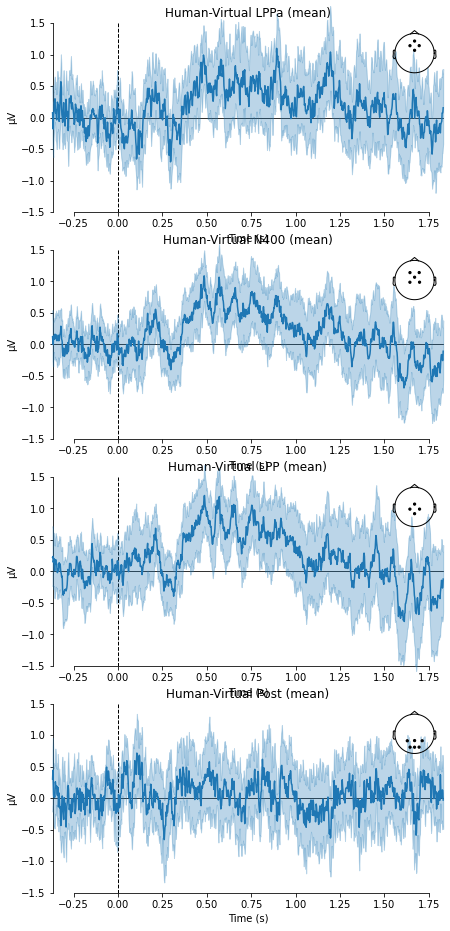

In [151]:
import matplotlib.pyplot as plt
waveplot_figsize = (7, 16)
ylim = {'eeg':[-1.5, 1.5]}

for contr in contrasts:
    fig, axs = plt.subplots(4, 1, figsize=waveplot_figsize)   
    ax = 0
    for roi, chans in roi_mapping.items():
        if ax < 3:
            show=False
        else:
            show=True
            
        mne.viz.plot_compare_evokeds(evoked_diff,
                                     picks=chans, combine='mean',
                                     title=(contr + ' ' + roi),
                                     ylim=ylim,
                                     show_sensors='upper right', legend=False, 
                                     ci=True,
                                     axes=axs[ax], show=show
                                    )
        ax += 1
        
#     plt.tight_layout()
    plt.show()

### Only at vertex roi

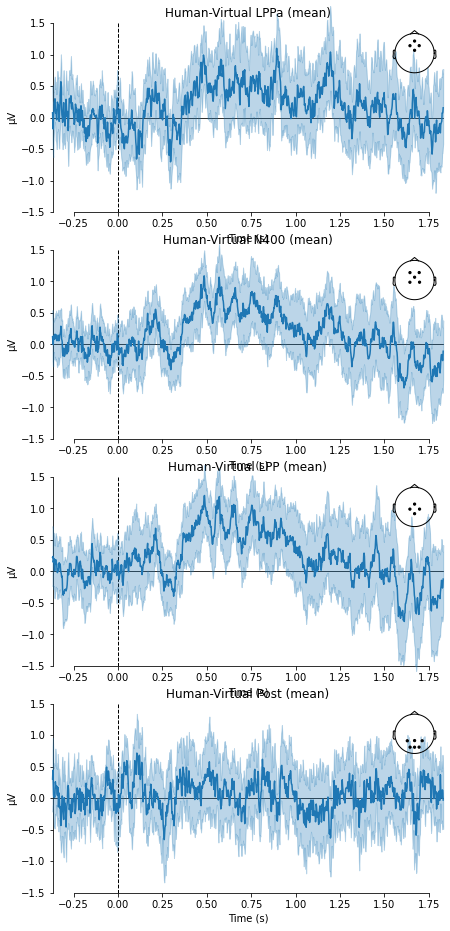

In [151]:
import matplotlib.pyplot as plt
waveplot_figsize = (7, 16)
ylim = {'eeg':[-1.5, 1.5]}

for contr in contrasts:
    fig, axs = plt.subplots(4, 1, figsize=waveplot_figsize)   
    ax = 0
    for roi, chans in roi_mapping.items():
        if ax < 3:
            show=False
        else:
            show=True
            
        mne.viz.plot_compare_evokeds(evoked_diff,
                                     picks=chans, combine='mean',
                                     title=(contr + ' ' + roi),
                                     ylim=ylim,
                                     show_sensors='upper right', legend=False, 
                                     ci=True,
                                     axes=axs[ax], show=show
                                    )
        ax += 1
        
#     plt.tight_layout()
    plt.show()

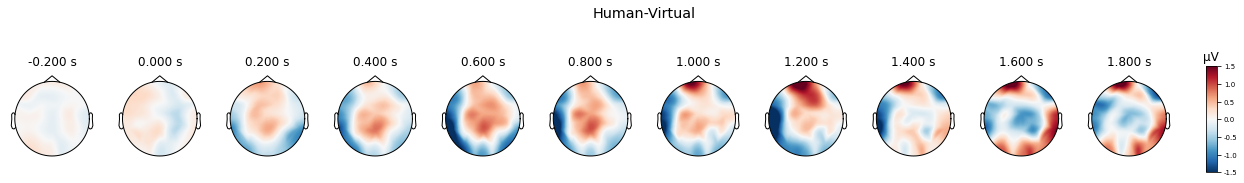

In [114]:
times = np.arange(-0.2, 2, 0.2)

uv_range = 1.5

for contr in contrasts:
     mne.grand_average(evoked_diff[contr]).plot_topomap(times, average=0.050,
                                                       ch_type='eeg', 
                                                       show_names=False, sensors=False, contours=False, 
                                                       colorbar=True, 
                                                       vmin=-uv_range, vmax=uv_range,
                                                       title=(contr)
                                                      )

### Condition Plot for the N400 Timeframe: 200 - 600s

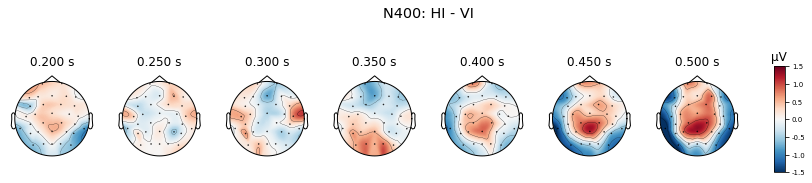

In [157]:
diff = mne.combine_evoked([gavg['HI'], -gavg['VI']], weights="equal")
# times = np.arange(0.2, 0.6, 0.1)
times = np.arange(0.2, 0.51, 0.05)
uv_range = 1.5


#comp[0].dpi = 300
#comp[0].savefig('fig2_grand_average.jpg')

difference = mne.grand_average(evoked_diff[contr]).plot_topomap(outlines='head', times=times, 
                                vmin=-uv_range, vmax=uv_range,
                               title="N400: HI - VI")
difference.dpi = 300
difference.savefig('fig2_gavg_N400_topomap.png')

### LPP timeframe

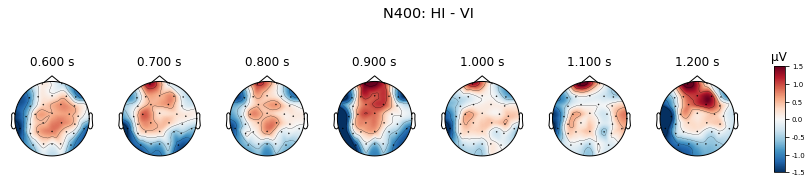

In [140]:
diff = mne.combine_evoked([gavg['HI'], -gavg['VI']], weights="equal")
# times = np.arange(0.2, 0.6, 0.1)
times = np.arange(0.6, 1.201, .1)
uv_range = 1.5


#comp[0].dpi = 300
#comp[0].savefig('fig2_grand_average.jpg')

difference = mne.grand_average(evoked_diff[contr]).plot_topomap(outlines='head', times=times, 
                                vmin=-uv_range, vmax=uv_range,
                               title="LPP: HI - VI")
difference.dpi = 300
difference.savefig('fig2_gavg_LPP_topomap.png')

---
# Look at data re-referenced to average mastoids
Also reverse the subtraction relative to how done above, since for N400 we typically do the condition expected to have larger N400 - condition expected to have smaller.

Note that in this case re-referencing to mastoids seems to have virtually no effect on the scalp distributions

In [120]:
epochs_mstd = {}
for subject in subjects:
    epochs_mstd[subject] = epochs[subject].copy().set_eeg_reference(ref_channels=['TP9', 'TP10'])


In [121]:
evoked_mstd = {}

for cond in conditions:
    evoked_mstd[cond] = [epochs_mstd[subject][cond].average() for subject in subjects]

In [123]:
gavg_mstd = {}
for cond in conditions:
    gavg_mstd[cond] = mne.grand_average(evoked_mstd[cond])
gavg_mstd  

{'HI': <Evoked | 'Grand average (n = 22)' (average, N=22), -0.36822 – 1.831 sec, baseline -0.368219 – 0 sec, 32 ch, ~333 kB>,
 'VI': <Evoked | 'Grand average (n = 22)' (average, N=22), -0.36822 – 1.831 sec, baseline -0.368219 – 0 sec, 32 ch, ~333 kB>}

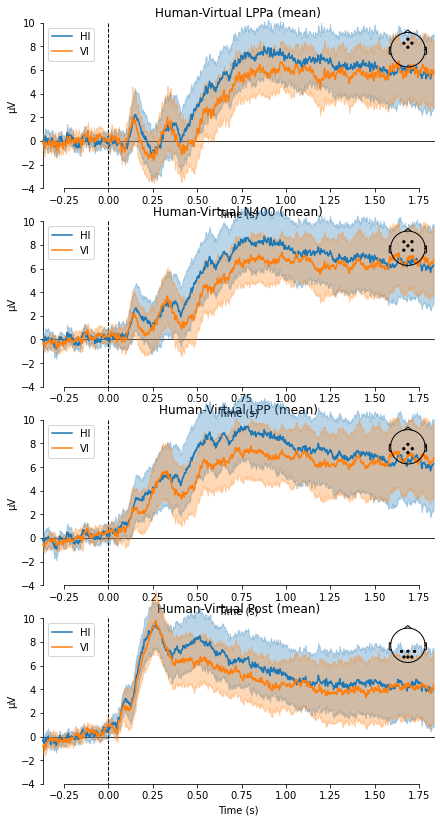

In [131]:
import matplotlib.pyplot as plt
waveplot_figsize = (7, 14)
ylim = {'eeg':[-4, 10]}

for contr in contrasts:
    fig, axs = plt.subplots(4, 1, figsize=waveplot_figsize)   
    ax = 0
    for roi, chans in roi_mapping.items():
        if ax < 3:
            show=False
        else:
            show=True
            
        mne.viz.plot_compare_evokeds({c:evoked_mstd[c] for c in conditions},
                                     picks=chans, combine='mean',
                                     title=(contr + ' ' + roi),
                                     ylim=ylim,
                                     show_sensors='upper right', legend=True, 
                                     ci=True,
                                     axes=axs[ax], show=show
                                    )
        ax += 1
    plt.show()

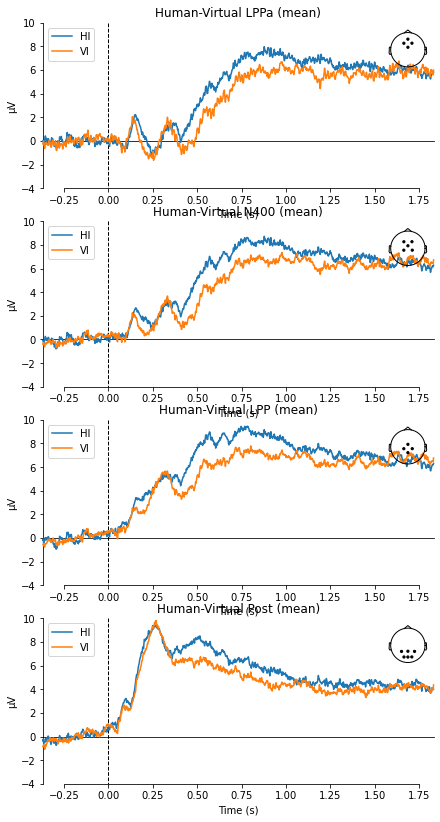

In [132]:
import matplotlib.pyplot as plt
waveplot_figsize = (7, 14)
ylim = {'eeg':[-4, 10]}

for contr in contrasts:
    fig, axs = plt.subplots(4, 1, figsize=waveplot_figsize)   
    ax = 0
    for roi, chans in roi_mapping.items():
        if ax < 3:
            show=False
        else:
            show=True
            
        mne.viz.plot_compare_evokeds({c:evoked_mstd[c] for c in conditions},
                                     picks=chans, combine='mean',
                                     title=(contr + ' ' + roi),
                                     ylim=ylim,
                                     show_sensors='upper right', legend=True, 
                                     ci=False,
                                     axes=axs[ax], show=show
                                    )
        ax += 1
    plt.show()

# Plot midline electrodes

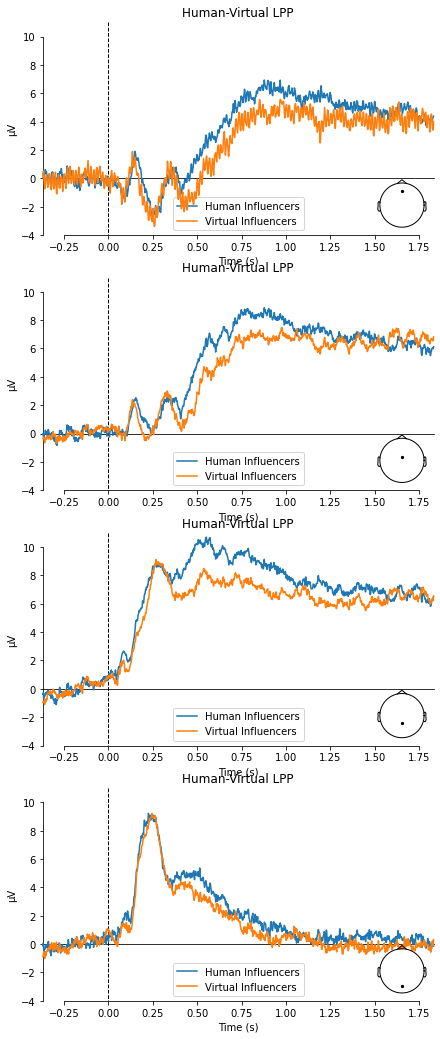

In [164]:
import matplotlib.pyplot as plt
waveplot_figsize = (7, 18)
ylim = {'eeg':[-4, 11]}
mid_elec = ['Fz', 'Cz', 'Pz', 'Oz']

for contr in contrasts:
    fig, axs = plt.subplots(4, 1, figsize=waveplot_figsize)   
    ax = 0
    for chans in mid_elec:
        if ax < len(mid_elec):
            show=False
        else:
            show=True
            
        mne.viz.plot_compare_evokeds({'Human Influencers':evoked_mstd['HI'], 
                                      'Virtual Influencers':evoked_mstd['VI']},
                                     picks=chans, combine='mean',
                                     title=(contr + ' ' + roi),
                                     ylim=ylim,
                                     show_sensors='lower right', legend='lower center', 
                                     ci=False,
                                     axes=axs[ax], show=show
                                    )
        
        ax += 1

    fig.savefig('./fig1_waveforms_aaron.png', dpi=300)
    plt.show()

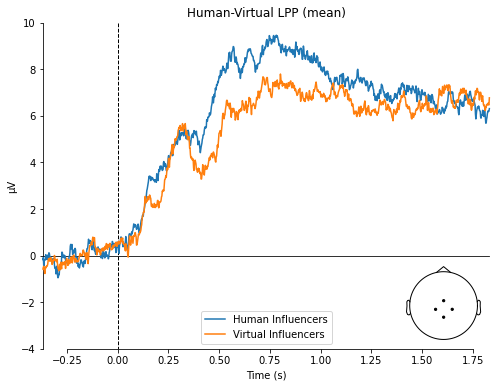

In [165]:
import matplotlib.pyplot as plt
waveplot_figsize = (7, 14)
ylim = {'eeg':[-4, 10]}

for contr in contrasts:
    roi = 'LPP'
            
    mne.viz.plot_compare_evokeds({'Human Influencers':evoked_mstd['HI'], 
                                  'Virtual Influencers':evoked_mstd['VI']},
                                 picks=roi_mapping[roi], combine='mean',
                                 title=(contr + ' ' + roi),
                                 ylim=ylim,
                                 show_sensors='lower right', legend='lower center', 
                                 ci=False,
                                )

    fig.savefig('./fig1b_waveforms_roi_aaron.png', dpi=300)
    plt.show()

## Contrasts, mastoid-referenced

In [124]:
evoked_diff_mstd = {}
for contr, conds in contrasts.items():
    evoked_diff_mstd[contr] = [mne.combine_evoked([ c1, c2],
                                                  weights=[1, -1])
                               for (c1, c2) in zip(evoked_mstd[conds[0]], evoked_mstd[conds[1]])
                              ]

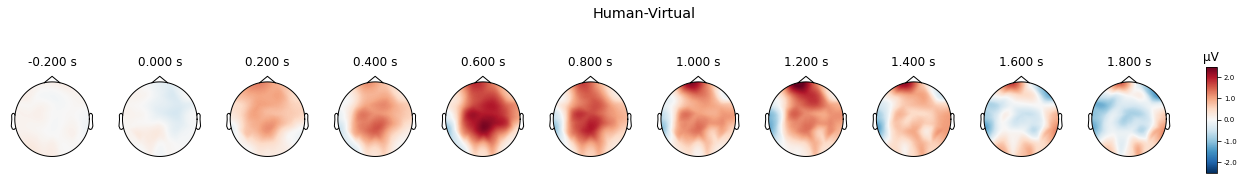

In [148]:
times = np.arange(-0.2, 2, 0.2)

uv_range = 2.5

for contr in contrasts:
     mne.grand_average(evoked_diff_mstd[contr]).plot_topomap(times, average=0.100,
                                                       ch_type='eeg', 
                                                       show_names=False, sensors=False, contours=False, 
                                                       colorbar=True, 
                                                       vmin=-uv_range, vmax=uv_range,
                                                       title=(contr)
                                                      )

### Condition Plot for the N400 Timeframe: 200 - 600s

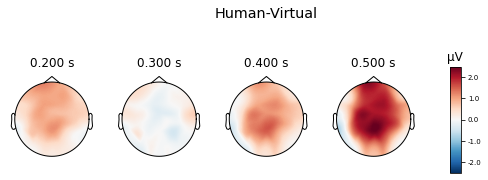

In [182]:
times = np.arange(.2, .501, 0.1)

uv_range = 2.5

for contr in contrasts:
     mne.grand_average(evoked_diff_mstd[contr]).plot_topomap(times, average=0.10,
                                                       ch_type='eeg', 
                                                       show_names=False, sensors=False, contours=False, 
                                                       colorbar=True, 
                                                       vmin=-uv_range, vmax=uv_range,
                                                       title=(contr)
                                                      )

### LPP timeframe

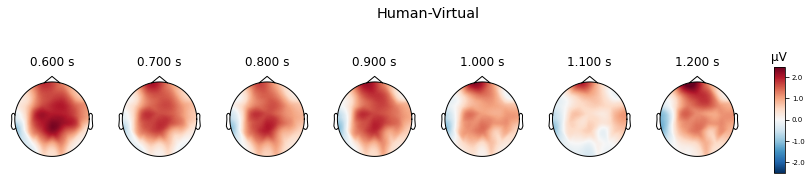

In [183]:
times = np.arange(0.6, 1.201, .1)
uv_range = 2.5

for contr in contrasts:
     mne.grand_average(evoked_diff_mstd[contr]).plot_topomap(times, average=0.100,
                                                       ch_type='eeg', 
                                                       show_names=False, sensors=False, contours=False, 
                                                       colorbar=True, 
                                                       vmin=-uv_range, vmax=uv_range,
                                                       title=(contr)
                                                      )

## Both time windows

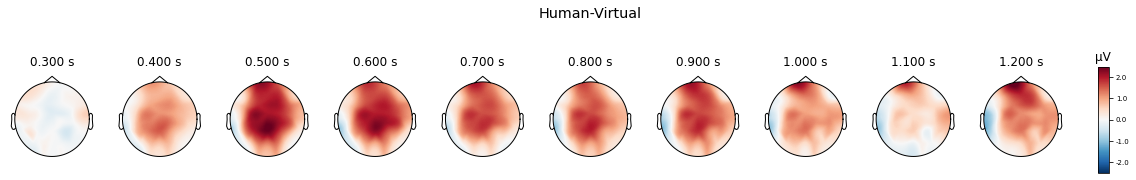

In [186]:
times = np.arange(0.3, 1.201, .1)
uv_range = 2.5

for contr in contrasts:
     mne.grand_average(evoked_diff_mstd[contr]).plot_topomap(times, average=0.100,
                                                       ch_type='eeg', 
                                                       show_names=False, sensors=False, contours=False, 
                                                       colorbar=True, 
                                                       vmin=-uv_range, vmax=uv_range,
                                                       title=(contr)
                                                      ).savefig('./fig3_diff_topos_aaron.png', dpi=300)
        

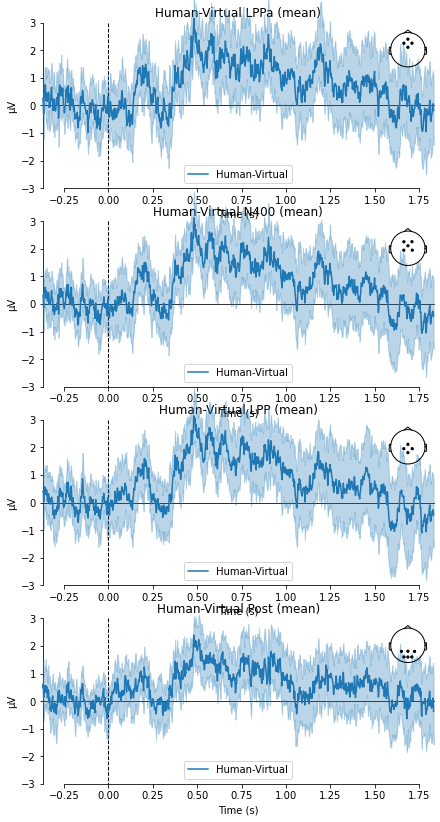

In [166]:
import matplotlib.pyplot as plt
waveplot_figsize = (7, 14)
ylim = {'eeg':[-3, 3]}

for contr in contrasts:
    fig, axs = plt.subplots(4, 1, figsize=waveplot_figsize)   
    ax = 0
    for roi, chans in roi_mapping.items():
        if ax < 3:
            show=False
        else:
            show=True
            
        mne.viz.plot_compare_evokeds(evoked_diff_mstd,
                                     picks=chans, combine='mean',
                                     title=(contr + ' ' + roi),
                                     ylim=ylim,
                                     show_sensors='upper right', legend='lower center', 
                                     ci=True,
                                     axes=axs[ax], show=show
                                    )
        ax += 1
    plt.show()

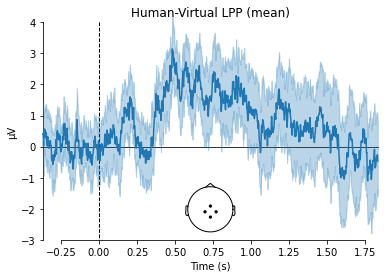

In [181]:
import matplotlib.pyplot as plt
waveplot_figsize = (7, 7)
ylim = {'eeg':[-3, 4]}

for contr in contrasts:
    roi = 'LPP'
    fig, axs = plt.subplots(1, 1)        
    mne.viz.plot_compare_evokeds(evoked_diff_mstd,
                                 picks=roi_mapping[roi], combine='mean',
                                 title=(contr + ' ' + roi),
                                 ylim=ylim,
                                 show_sensors='lower center', legend=False, 
                                 ci=True,
                                 axes=axs
                                )

    fig.savefig('./fig2_diff_waves_roi_aaron.png', dpi=300)
    plt.show()